# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [ ]:
repository_name = "class_notebooks"
repository_url = 'https://github.com/renero/' + repository_name

In [ ]:
! git clone $repository_url

Install the requirements

In [ ]:
! pip install -Uqqr $repository_name/requirements.txt

Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

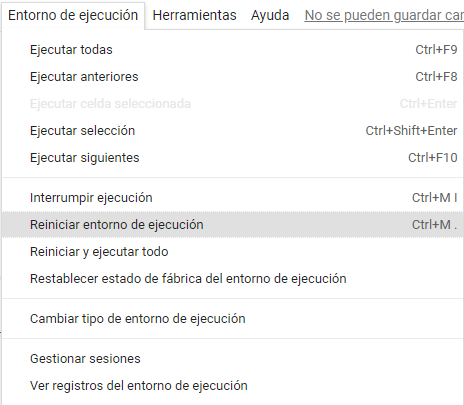

# Naive Bayes Practice

Go to the practice directory



In [ ]:
%cd "$repository_name/NaiveBayes Practice"

The following code includes some imports and configuration steps for better visualization

In [4]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') # Do not print warning messages

In [5]:
import pandas as pd
import math

# Introduction
Welcome to the first application of Probabilistic classification with Naïve Bayes!

<html>
<img src="https://www.sketchappsources.com/resources/source-image/twitterlogo_1x.png" width="20%">
</html>


# Exercise #1

In this example we will use **Twitter** as our data source to filter those tweets that are talking about a given application. This is a typical problem in probabilistic classification, where I'll use a large sample of texts corresponding to the category that I want to recognize, and another large sample of texts unrelated to that category. That way, by exploring the different word frequencies and probabilities, we'll determine if a new text belongs to one or another category, by simply looking at the existing evidence.

## Problem Statement

I want to scan twitter to capture only those tweets that mention my APP. But I don't want to read tweets talking about the animal (the actual mandrill), so I need a classifier for the tweets, that will **filter** only those which are relevant.

For this part of the problem part of the data preparation job is already done, so you start with a few hundreds tweets captured using Twitter API, with the word **Mandrill** in them. The file with tweets (`appWords.txt`) referring to the app looks like this:

    @ericcandino they're unfortunately not for sale but drop us a line via http://help.mandrill.com  a
    @gidogeek you can see what we've been working on and get a general idea of our plans at http://blo
    @guillaumepotier there are several reasons emails go to spam mind submitting a request at http://h

And the file with tweets (`otherWords.txt`) not talking about the app look like this:

    anyway  yeah  that's a thing that's going on  reincarnated mandrill-men
    arin did the spark mandrill trick i was wondering if he would :')
    audio mandrill - happy beat this is a funk song by a band who liked to w

I trimmed lines for better representation, but they're arbitrarily long (within twitter limits). As you might probably have realized, this is a **supervised problem**, and the _labeling_ of the training data has been already done, by manually separating the tweets among the two possible sets. That is the most boring part, and you always need to do so to train any classifier.

## Data Preparation

What I did to prepare the problem is to process the tweets to convert _raw_ two data files with the frequency count for each individual word on them. So, from `appWords.txt`, I generated `appFreqs.csv`, which summary is like:

In [15]:
appFile = pd.read_csv("data/appFreqs.csv", header=None,
                      names=["word", "frequency"])
otherFile = pd.read_csv("data/otherFreqs.csv",
                        header=None, names=["word", "frequency"])

These files contains a list of words and their frequency. We need to compute the probabilities from these frequencies (i.e., number of times a word appears w.r.t. the total count of words).

To that end, I did simply count the number of occurrences of each word (`frequency`), divided by the sum of occurrences of all the words, and put that in the column variable `probability`, but I also computed the $log$ of the probability. Remember the we can use the actual probability as:

$$ P(word) = \frac{count(word)}{\sum_{i=1}^{N}count(word_{i})} $$

or the $log(P)$, as it is more convenient to use those values than the tiny ones that the probability produces. Remember that when using $logs$ we must sum them, instead of multiplying them. So, what we have in the variable `probability` is:

$$ logP(word) = log \left( \frac{count(word)}{\sum_{i=1}^{N}count(word_{i})} \right)  $$

In [16]:
appTotal = sum(appFile.frequency)
otherTotal = sum(otherFile.frequency)

appFile['probability'] = appFile.frequency.apply(
    lambda x: math.log(x/appTotal))
otherFile['probability'] = otherFile.frequency.apply(
    lambda x: math.log(x/otherTotal))

In [17]:
appFile.head()

,word,frequency,probability
0,#atl,30,-7.705262
1,#atlanta,30,-7.705262
2,#bjcbranding,30,-7.705262
3,#buddypress,30,-7.705262
4,#career,30,-7.705262


## Helper functions


I need a function gives me a word probability in any of the data frames that I used for the two classes.

In [18]:
def get_w_prob(word, dataframe):
    prob = dataframe[dataframe.word == word].probability
    if len(prob) > 0:
        return prob.values[0]
    else:
        return 1/math.log(sum(dataframe.frequency))


get_w_prob("#al", appFile)

0.09003769094003349

I also need to compute the prior probability of each class

In [19]:
# Number of Tweets in app File / Total number of Tweets (sum of the number of tweets in both files)
appPrior = math.log(len(appFile) / (len(appFile) + len(otherFile)))
print("The prior of tweets belonging to the app is = {0:.2f}\n".format(
    math.exp(appPrior)))

# Number of Tweets in other File / Total number of Tweets (sum of the number of tweets in both files)
otherPrior = math.log(len(otherFile) / (len(appFile) + len(otherFile)))
print("The prior of tweets NOT belonging to the app is = {0:.2f}".format(
    math.exp(otherPrior)))

The prior of tweets belonging to the app is = 0.48

The prior of tweets NOT belonging to the app is = 0.52


### The Bayesian classifier. 

Let's build the classifier. I'm using a test set with a few tweets (`test.csv`), and the goal is to read them and say if they are about the APP or not. The test set is already labeled with the class each belongs to in the first column. We will loose that information to check if our prediction is OK.

Read a test file, with the category label in V1 and the tweet contents in V2.


In [20]:
test = pd.read_csv("data/test.csv", header=None, 
                   names=["label", "content"])

Now, let's loop through the file to compute the MAP (maximum A Posterior Probability) and thus, determine which class the tweet belongs to:

In [ ]:
pred = []
for j in range(0, len(test)):
    tweet = test.iloc[j].content  
    print("Processing tweet:", tweet)
    wordsInThisTweet = tweet.strip().split(" ")  
    appProb = 0.0
    otherProb = 0.0

    # For every word in this tweet, sum its frequency value.
    for word in wordsInThisTweet:
        appProb = appProb + get_w_prob(word, appFile)
        otherProb = otherProb + get_w_prob(word, otherFile)

    posteriorAppPob = appProb * appPrior
    posteriorOtherPob = otherProb * otherPrior

    # Categorize according to the score obtained from every 
    # subset (App tweets, and Other tweets)
    if posteriorAppPob > posteriorOtherPob:
        print(f"  Pred.: APP; Actual Label = {test.iloc[j].label}")
        pred.append("APP")
    else:
        print(f"  Pred.: OTHER; Actual Label = {test.iloc[j].label}")
        pred.append("OTHER")

Let's now print the confusion matrix

Accuracy = 0.85

Confusion Matrix


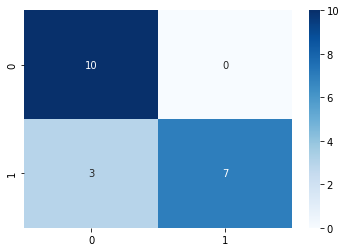

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn


print("Accuracy = {}".format(accuracy_score(test.label, pred)))
print("Confusion Matrix")
cm = confusion_matrix(test.label, pred)
sn.heatmap(cm, annot=True, cmap=plt.cm.Blues)

An amazing 85% of Accuracy with this simple implementation

# Exercise #2
We are going to play now with another application of Naive Bayes: positive/negative prediction.

## Problem Statement

We will apply Naive Bayes to classify movie reviews according to their overall sentiment (positive/negative). In particular, we will use the Pang and Lee’s IMDB movie reviews data which contains 2000 reviews, each with a positive or negative sentiment label.

I recommend you to take a look to the entry in the sklearn documentation devoted to working with textual representations: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


## Data Preparation

Read the IMDB dataset from the data folder

In [6]:
dataset = pd.read_csv("data/movie-pang02.csv")

# Randomize the dataset to facilitate the training process
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [7]:
dataset.head()

,class,text
0,Neg,there were four movies that earned jamie lee ...
1,Pos,as the small boats rock slowly toward the sho...
2,Neg,lake placid marks yet another entry in t...
3,Neg,there are those of us who think of leslie nie...
4,Neg,the high school comedy seems to be a hot genr...


In order to be able to manage the text documents, we first need to transform the text content into numerical feature vectors (i.e., vectorize).



In [8]:
from sklearn.feature_extraction.text import CountVectorizer


count_vect = CountVectorizer()
dataset_counts = count_vect.fit_transform(dataset.text)
dataset_counts.shape

(2000, 39363)

We have created a new structure with 2000 documents (the original 2000 reviews) and almost 40k features! (each one of the unique words in the dataset). Although this matrix is huge, it is mostly sparse (full of zeros). The `CountVectorizer` takes advantage of this aspect and creates a special Python object (a sparse matrix that only stores the non-zero positions).

Each row in the dataframe `dataset_counts` represents how many times each of the ~ 40k words is present on each document (2000).

In [9]:
pd.DataFrame(dataset_counts.A, columns=count_vect.get_feature_names())

,00,000,0009f,007,00s,03,04,05,05425,10,...,zukovsky,zulu,zundel,zurg,zus,zweibel,zwick,zwigoff,zycie,zzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Naïve Bayes Model

Making use of the `naive_bayes` package (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes), compute the `cross_val_score` of the classifier.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
import numpy as np


naive_bayes_clf = BernoulliNB()
scores = cross_val_score(
    naive_bayes_clf, dataset_counts, dataset['class'], cv=10)
print("Naive Bayes Accuracy = {0:.4f}".format(np.mean(scores)))

Naive Bayes Accuracy = 0.7980


In [11]:
print("Scores: " + ", ".join([f"{score:.2f}" for score in scores]))

Scores: 0.77, 0.85, 0.86, 0.72, 0.78, 0.77, 0.85, 0.79, 0.80, 0.79


Almost 80 % of accuracy. Not bad for our basic and `naive` classifier.

In case you want to validate the confusion matrix

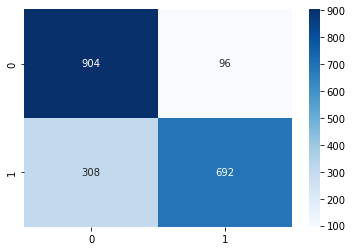

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sn


y_pred = cross_val_predict(naive_bayes_clf, dataset_counts, dataset['class'], cv=10)
cm = confusion_matrix(dataset['class'], y_pred)

sn.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt=".0f");